# **Exponential Low Pass Filter for groundwater estinmation from Sentinel-1 VSM**

* Author: Calvin Samwel Swai, 9th April 2024

# **Introduction**

Welcome to this notebook, where we introduce a tool for the implementation of Exponential Low Pass Filter (ELPF) algorithm to estimate groundwater time series from the Sentinel-1 retrieved Volumetric Soil Moisture (VSM) time series. The aim of this notebook is to estimate groundwater time series from Sentinel-1 retrieved Volumetric Soil Moisture (VSM) data as part of a research project at Vitens. For detailed information on the required datasets and formats, please refer to the accompanying report.

The ELPF algorithm is employed to synchronize surface soil moisture signals with groundwater level dynamics. It incorporates a parameter, denoted as "T" (in days), which accounts for various hydro-meteorological and soil factors influencing the interaction between surface and subsurface water reservoirs. For an in-depth understanding of ELPF, readers are encouraged to consult the work of Wagner et al. (1999).

The procedures outlined in this notebook are organized into five sections:



1. **Preparations and Environment sett-up**.
* This section involves preliminary steps such as installing and importing necessary libraries, as well as configuring the working environment.    

2. **Data input**.
* Sentinel-1 VSM and Groundwater level time series are the primary data for the analysis.
* Weather dataset such as snow cover days, air temperature and precipitation time series are useful for data processing and cleaning step.


3. **Data processing and cleaning**.
* Weather related uncertainties discussed by H. J. F. Benninga et al., 2020 and H.-J. F. Benninga et al., 2019 were the primary data cleaning procedures conducted in this notebook.
* Additional processing includes date and time column definition, temporal matching of Sentinel-1 VSM, groundwater and weather data time series, and finally outlier detection through scatterplots


4. **Low Pass Filter Application**

* After creating a subset of years of interest, ELPF algorithm was iterated through the dataset, annually calibration to determine the optimal delayed T for each study year. The optimal T value was determined as the one which yield the highest correlation score with the groundwater time series.
* The recursive ELPF formular introduced by Albergel et al., (2008) was adopted in this notebook.
* Finally the list of annual calibrated optimal delayed time is applied to the VSM time series to compute Volumetric Soil Water Index (VSWI)


5. **Groundwater Prediction**

* A simple univariate linear regression model was created with VSWI and groundwater time series as the explanatory and dependent variables respectively.Fitting was conducted in two steps: first, over the entire time series to evaluate overall fitting accuracy, and second, separately for each year to assess the strength of relations across study years.  
* In both approaches Root Mean Square Error (RMSE), correlation score, and Standard error of the slope were used to evaluate the strength of the relation and the fitting accuracy




# **1. Preparations and Environment Setting up**

---



**a. Importing useful libraries**

In [1]:
import os # To interact with the operating systems
import pandas as pd # Creation and manipulation of dataframes
import seaborn as sns # Data visulizations
import matplotlib.pyplot as plt # Data visulizations

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression # Fit linear regression model
from sklearn.metrics import mean_squared_error, r2_score # Statistical metrices for regression results evaluation
import numpy as np # Scientific computations

**b. Connecting to the working directory**

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the directory you want to change to
directory_path = '/content/drive/MyDrive/Intern'

# Change the working directory
os.chdir(directory_path)

Mounted at /content/drive


# **2. Data input**

**a. Sentinel-1 estimated Soil Moisture time series (s01_sm)**

In this case, Sentinel-1 VSM, product of Change detection  method on Sentinel-1 backscatter was used. The computations were adopted from https://developers.google.com/earth-engine/sentinel1


In [3]:
# Sentinel-1 VSM (Soil Moisture dataset)
s01_sm=pd.read_csv('/content/drive/MyDrive/Intern/Week_6/Retake2/B22C0131-001.csv')
s01_sm['date']=pd.to_datetime(s01_sm['system:time_start']) #Renaming the date column
s01_sm.head()

,system:time_start,b1,date
0,2014-10-03 05:41:22,0.311,2014-10-03 05:41:22
1,2014-10-08 05:49:33,0.274,2014-10-08 05:49:33
2,2014-10-15 05:41:22,0.388,2014-10-15 05:41:22
3,2014-10-27 05:41:23,0.284,2014-10-27 05:41:23
4,2014-11-16 17:24:44,0.345,2014-11-16 17:24:44


**b. Groundwater time series dataset (gw)**

Vitens Witharen groundwater monitoring wells were used in this study. a 3-hour temporal resolution measurements were acquired from the host department.




In [4]:
gw=pd.read_csv('GW_Data/B22C0131_1_20231101.csv')
ground_level=5.8807497 #Surface ground level (m) for depth computations
gw=gw.rename(columns={'peil_datum_tijd':'date','GW stand tov NAP [m]':'GW_level'}) #Renaming date and groundwater level columns
gw.head()

,date,Bussiness ID,filter_nr,GW_level,flag
0,1987-12-14 12:00:00,22CP0131001,1,4.91,betrouwbaar
1,1987-12-28 12:00:00,22CP0131001,1,4.86,betrouwbaar
2,1988-01-14 12:00:00,22CP0131001,1,5.10,betrouwbaar
3,1988-01-27 12:00:00,22CP0131001,1,5.15,betrouwbaar
4,1988-02-15 12:00:00,22CP0131001,1,5.27,betrouwbaar


**C. Weather dataset (weather_df)**

Weather information from Heino weather KNMI station which is 16.7 Km from Witharen town center was used as the primary weather dataset.

In [5]:
#Dates with biased weather conditions
weather_df=pd.read_csv('Weather/Heino_Weather_Station.csv')
weather_df['Date'] = pd.to_datetime(weather_df['Date'], format='%d/%m/%Y') # Defining date column
weather_df=weather_df.rename(columns={'Date':'date'}) #Renaming date column for consistency

# **3. Data cleaning and processing**

**a. Sentinel-1 VSM time series processing**

  i) Date and time preprocessing to match the groundwater to match groundwater acquisitions.

In [6]:
s01_sm['date'] = s01_sm['date'].astype(str)
s01_sm[['date', 'time']] = s01_sm['date'].str.split(expand=True) # Separating date and time to different columns

# Define a function to map values
def map_time(time):
    if time.startswith('05'):
        return '06:00:00'
    elif time.startswith('17'):
        return '18:00:00'
    else:
        return time

# Apply the function to create the 'time_g' column with values matching 6:00 and 18:00, the acqisition time of groundwater dataset
s01_sm['time_g'] = s01_sm['time'].apply(map_time)
s01_sm=s01_sm.drop('time', axis=1)

s01_sm=s01_sm.rename(columns={'time_g':'time'})

s01_sm['datetime'] = pd.to_datetime(s01_sm['date'] + ' ' + s01_sm['time']) # Recreating the date and time column
s01_sm.head()

,system:time_start,b1,date,time,datetime
0,2014-10-03 05:41:22,0.311,2014-10-03,06:00:00,2014-10-03 06:00:00
1,2014-10-08 05:49:33,0.274,2014-10-08,06:00:00,2014-10-08 06:00:00
2,2014-10-15 05:41:22,0.388,2014-10-15,06:00:00,2014-10-15 06:00:00
3,2014-10-27 05:41:23,0.284,2014-10-27,06:00:00,2014-10-27 06:00:00
4,2014-11-16 17:24:44,0.345,2014-11-16,18:00:00,2014-11-16 18:00:00


**b. Weather time series preparation**

* Date formatting
* Computation of net precipitation time series and accumulated precipitation for the cleaning of the Sentinel-1 VSM timeseries
  * Net Precipitation (mm) = Precipitation (mm) - Evapotranspiration (mm)

In [7]:
weather_df['Date'] = pd.to_datetime(weather_df['date'])
weather_df['netRH'] = weather_df['RH']-weather_df[' EV24'] # Net precipitation computation


weather_df['Date'] = pd.to_datetime(weather_df['Date'])  # Convert the 'Date' column to datetime format
weather_df = weather_df.sort_values(by='Date')  # Sort the DataFrame by date if not already sorted

# Print the resulting DataFrame
weather_df.head()

,TG,Tmin,RH,EV24,date,SX,Date,netRH
0,7.0,4.3,0.4,0.4,2014-01-01,0,2014-01-01,0.0
1,8.4,5.4,0.5,0.2,2014-01-02,0,2014-01-02,0.3
2,8.3,4.0,9.7,0.1,2014-01-03,0,2014-01-03,9.6
3,7.2,5.5,-0.1,0.3,2014-01-04,0,2014-01-04,-0.4
4,5.9,3.8,2.1,0.4,2014-01-05,0,2014-01-05,1.7


**c. Cleaning Weather uncertainities (H. J. F. Benninga et al., 2020; H.-J. F. Benninga et al., 2019)**
* Frozen soil (Temperature < 1C)
* Snow cover (SX =1 )
* Heavy rainfall (RH =>10 mm)

In [8]:
# Selecting days with unsuitable weather conditions
selected_days=weather_df[(weather_df['Tmin']<=1) | (weather_df['RH']>=10)| (weather_df['SX']==1)].reset_index(drop=True) # Days to be filtered away

unfiltered=s01_sm
s01_sm['date']=pd.to_datetime(s01_sm['date'])
# Merge the DataFrames on the 'date' column
merged_df = pd.merge(s01_sm, selected_days, on='date', how='left', indicator=True)

# Filter rows where the date is only present in the 'sm' DataFrame
filtered_sm = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)

#Select sm station of interest
s01_sm=filtered_sm[['date','datetime','b1']]
s01_sm=s01_sm.rename(columns={'b1':'S01_sm'})

s01_sm.head()

,date,datetime,S01_sm
0,2014-10-03,2014-10-03 06:00:00,0.311
1,2014-10-08,2014-10-08 06:00:00,0.274
2,2014-10-15,2014-10-15 06:00:00,0.388
3,2014-10-27,2014-10-27 06:00:00,0.284
5,2014-11-28,2014-11-28 18:00:00,0.394


**d.  Preparation of Groundwater timeseries**

In [9]:
gw['depth']=ground_level-gw['GW_level'] # Groundwater depth computation
gw['date']=pd.to_datetime(gw['date']) # Making sure the date column is in datetime format


gw=gw.loc[gw['flag']=='betrouwbaar'] # Get reliable gw measurements

# Preparing groundwater date and time
gw['date'] = gw['date'].astype(str)
gw[['date', 'time']] = gw['date'].str.split(expand=True)
gw['datetime'] = pd.to_datetime(gw['date'] + ' ' + gw['time'])

gw.head()

,date,Bussiness ID,filter_nr,GW_level,flag,depth,time,datetime
0,1987-12-14,22CP0131001,1,4.91,betrouwbaar,0.97075,12:00:00,1987-12-14 12:00:00
1,1987-12-28,22CP0131001,1,4.86,betrouwbaar,1.02075,12:00:00,1987-12-28 12:00:00
2,1988-01-14,22CP0131001,1,5.10,betrouwbaar,0.78075,12:00:00,1988-01-14 12:00:00
3,1988-01-27,22CP0131001,1,5.15,betrouwbaar,0.73075,12:00:00,1988-01-27 12:00:00
4,1988-02-15,22CP0131001,1,5.27,betrouwbaar,0.61075,12:00:00,1988-02-15 12:00:00


**e. Temporal matching Sentinel-1 VSM with in-situ groundwater measurements**
* In this study temporal matching between groundwater and Sentinel-1 backscatter was done on hour scale, with measurements at 06:00 and 18:00 matched with Sentinel-1 backscatter at 05:40’s and 17:20’s respectively.

In [10]:
# Assuming 'date' is the datetime column in both dataframes
s01_sm['datetime'] = pd.to_datetime(s01_sm['datetime'])
gw['datetime'] = pd.to_datetime(gw['datetime'])

# Merging dataframes
sw_gw = pd.merge(s01_sm, gw, on='datetime', how='left')

# Sorting by 'date'
sw_gw = sw_gw.sort_values(by='datetime')

In [11]:
sw_gw_clean=sw_gw
sw_gw_clean=sw_gw_clean.dropna(subset=['S01_sm']).reset_index(drop=True) # Keeping the matched inputs/rows
sw_gw_clean = sw_gw_clean[sw_gw_clean['S01_sm'] >= 0].reset_index(drop=True) # Changing the negative soil moisture into 0

sw_gw_clean=sw_gw_clean[['datetime','S01_sm','GW_level','depth']] # Keeping the useful columns only
sw_gw_clean. head()

,datetime,S01_sm,GW_level,depth
0,2014-10-03 06:00:00,0.311,NaN,NaN
1,2014-10-08 06:00:00,0.274,NaN,NaN
2,2014-10-15 06:00:00,0.388,NaN,NaN
3,2014-10-27 06:00:00,0.284,NaN,NaN
4,2014-11-28 18:00:00,0.394,NaN,NaN


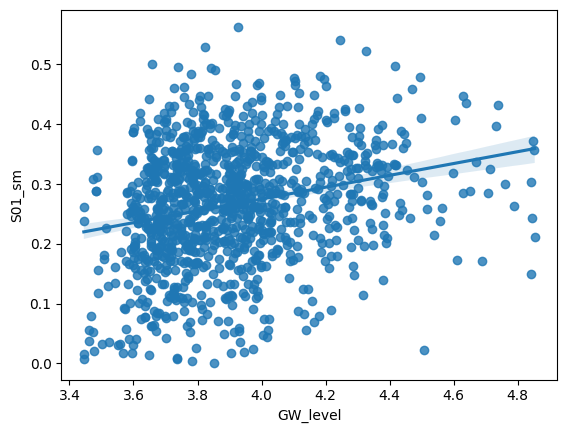

In [12]:
#Scatter plot
sns.regplot(x='GW_level', y='S01_sm', data=sw_gw_clean)
# Display the plot
plt.show()

# **4. Low Pass Filter Application**
* To synchronize soil moisture time series with groundwater dynamics, an Exponential Low-Pass Filter (ELPF) was applied, as per Wagner et al., (1999). ELPF presumes groundwater, deeper water storage, is less dynamic than surface storage. Calibration determined the optimal characteristic time length (T) between 1 to 100 days. Cross-correlation identified the best T value, aligning VSWI with groundwater level dynamics for effective analysis.
* Formular below represent the updated recursive low pass filter formular introduced by Albergel et al., (2008)

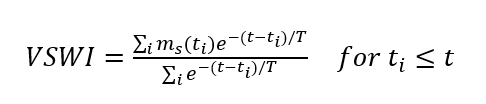

Where VSWI is the Volumetric Soil Water Index estimated at time index t using the remotely sensed soil moisture (VSM) at a time ti. T is the characteristic time length that accounts for depth and the pseudo diffusivity of water from top-most to the deep soil layer.

**a. Data preparation**

In [13]:
# Keeping the complete years
complete_years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
complete_mask = sw_gw_clean['datetime'].dt.year.isin(complete_years)

sw_gw_clean = sw_gw_clean[complete_mask] # Masking out incomplete years

sw_gw_clean.reset_index(drop=True, inplace=True) # Optional: Reset index if needed
sw_gw_clean.head()

,datetime,S01_sm,GW_level,depth
0,2016-01-10 18:00:00,0.418,4.225,1.65575
1,2016-01-26 06:00:00,0.274,4.202,1.67875
2,2016-01-29 18:00:00,0.422,4.262,1.61875
3,2016-01-29 18:00:00,0.426,4.262,1.61875
4,2016-01-31 06:00:00,0.349,4.324,1.55675


**Time series visualization**

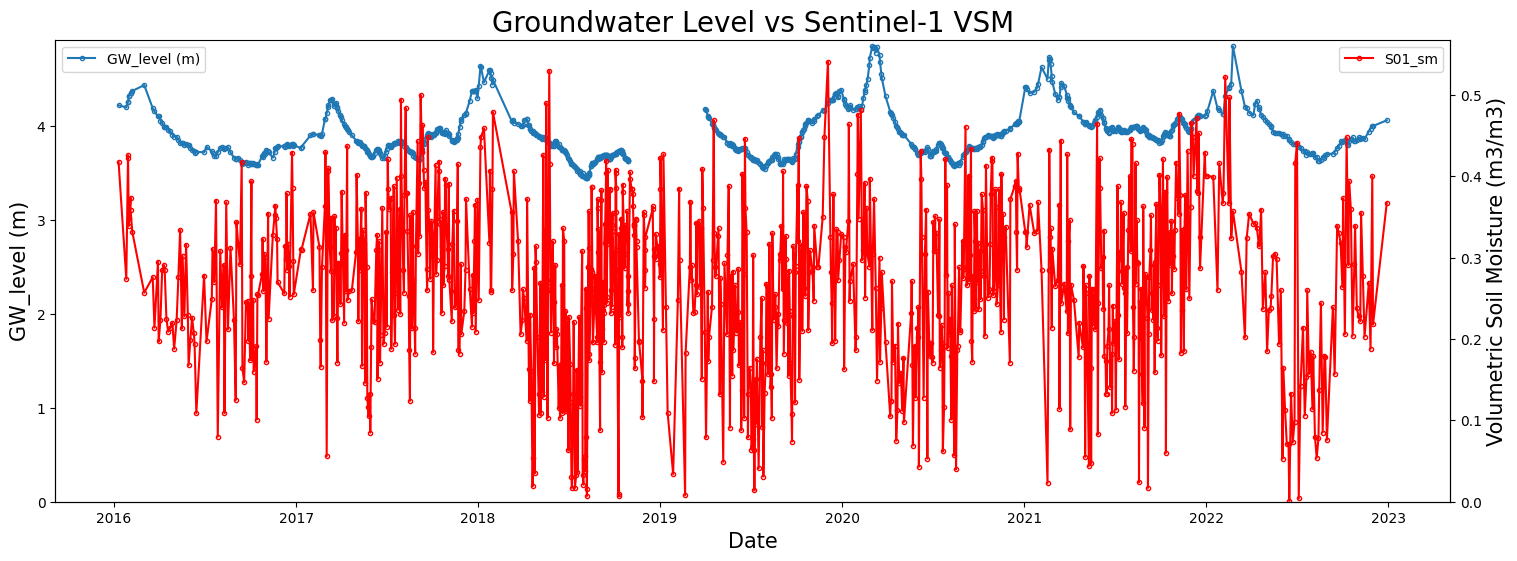

In [14]:
fig, ax1 = plt.subplots(figsize=(18, 6))
ax1.plot(sw_gw_clean['datetime'], sw_gw_clean['GW_level'], label='GW_level (m)', marker='o', markersize=3, markerfacecolor='none')
ax1.set_xlabel('Date', size=15)
ax1.set_ylabel('GW_level (m)', size=15)

ax2 = ax1.twinx()
ax2.plot(sw_gw_clean['datetime'], sw_gw_clean['S01_sm'], label='S01_sm', color='r', marker='o', markersize=3, markerfacecolor='none', markeredgecolor='r')
ax2.set_xlabel('Date', size=15)
ax2.set_ylabel('Volumetric Soil Moisture (m3/m3)', size=15)

# Set the bottom parameter to zero for ax2
ax2.spines['bottom'].set_position('zero')
ax2.spines['top'].set_color('none')  # Hide the top spine for better aesthetics
ax2.xaxis.tick_bottom()

# Adjust ylim to ensure both axes have the same scale
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

plt.title('Groundwater Level vs Sentinel-1 VSM', size=20)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

**b. Low Pass Filter Definition and Callibration**

*   Optimal delayed time for each year will be printed



In [15]:
# Group the DataFrame by year
grouped_by_year = sw_gw_clean.groupby(sw_gw_clean['datetime'].dt.year)

# Create a dictionary to store DataFrames for each year
df_collection = {}

# Iterate over the groups and store each DataFrame in the dictionary
for year, group_df in grouped_by_year:
    df_collection[year] = group_df

for year, df in df_collection.items():
    df_collection[year] = df.reset_index(drop=True)

In [34]:
# Defining Low Pass Filter function
def calculate_Kn_rzsm_and_find_top_2(df_collection, T_values):
    """
    Calculate Kn and rzsm values for DataFrames of different years based on the provided formula above
    and find the top 2 features based on correlation coefficient.

    Parameters:
    - df_collection: Dictionary containing DataFrames for different years, where the keys are the years.
    - T_values: List of T values to iterate over.

    Returns:
    - Dictionary containing calculated 'Kn' and 'rzsm' values and top 5 features based on correlation coefficient for each year.
    """
    results = {}

    for year, df in df_collection.items():
        # Function to calculate Kn and rzsm
        def calculate_Kn_rzsm(df, T):
            if len(df) < 2:
                return df

            df = df.copy()  # Make a copy to avoid modifying the original DataFrame
            df['datetime'] = pd.to_datetime(df['datetime'])
            df['Kn'] = 1
            df['rzsm'] = df['S01_sm']
            for i in range(1, len(df)):
                df.at[i, 'Kn'] = df.at[i-1, 'Kn'] / (df.at[i-1, 'Kn'] + np.exp(-((df.at[i, 'datetime'] - df.at[i-1, 'datetime']).days / T)))
                df.at[i, 'rzsm'] = df.at[i-1, 'rzsm'] + (df.at[i, 'Kn'] * (df.at[i, 'S01_sm'] - df.at[i-1, 'rzsm']))
            return df

        # Initialize DataFrame to store results
        result_df = pd.DataFrame()

        # Iterate through T values
        for T in T_values:
            current_df = df.copy()
            current_df = calculate_Kn_rzsm(current_df, T)
            result_columns = ['datetime', 'S01_sm', 'Kn', 'rzsm', 'GW_level']
            result_for_T = current_df[result_columns].rename(columns={'rzsm': f'rzsm_{T}'})
            result_df = pd.concat([result_df, result_for_T], axis=1)

        result_df = result_df.loc[:, ~result_df.columns.duplicated()]

        # Drop rows with NaN values in 'GW_level' and 'S01_sm' columns
        result_df = result_df.dropna(subset=['GW_level', 'S01_sm']).reset_index(drop=True)

        # Compute correlation coefficient between 'GW_level' and each feature
        feature_columns = result_df.columns.difference(['datetime', 'Kn', 'GW_level'])
        correlation_coefficients = result_df[feature_columns].corrwith(result_df['GW_level'])

        # Find top 2 features based on correlation coefficient
        top_2_matches = correlation_coefficients.abs().nlargest(2)

        results[year] = {
            'result_df': result_df,
            'top_2_features': top_2_matches
        }

    return results


In [35]:
# Iterating Low Pass Filter through the selected years:

for year in [2016,2017,2018,2019,2020,2021,2022]:
    # Get the DataFrame for the current year from df_collection
    current_df = df_collection.get(year)

    # Check if the DataFrame is not empty
    if current_df is not None and not current_df.empty:
        # Calculate Kn, rzsm, and find top 5 features for the current year
        results = calculate_Kn_rzsm_and_find_top_2({year: current_df}, range(1, 101))

        # Print the results for the current year
        print(f"Results for year {year}:")
        print("Top 2 Delayed time based on correlation coefficient:")
        print(results[year]['top_2_features'])
        print()
    else:
        print(f"No data available for year {year}.")

Results for year 2016:
Top 2 Delayed time based on correlation coefficient:
rzsm_100    0.937666
rzsm_99     0.937399
dtype: float64

Results for year 2017:
Top 2 Delayed time based on correlation coefficient:
rzsm_100    0.459169
rzsm_99     0.458138
dtype: float64

Results for year 2018:
Top 2 Delayed time based on correlation coefficient:
rzsm_100    0.886899
rzsm_99     0.886508
dtype: float64

Results for year 2019:
Top 2 Delayed time based on correlation coefficient:
rzsm_28    0.884456
rzsm_27    0.884336
dtype: float64

Results for year 2020:
Top 2 Delayed time based on correlation coefficient:
rzsm_100    0.885157
rzsm_99     0.884295
dtype: float64

Results for year 2021:
Top 2 Delayed time based on correlation coefficient:
rzsm_100    0.771179
rzsm_99     0.769668
dtype: float64

Results for year 2022:
Top 2 Delayed time based on correlation coefficient:
rzsm_48    0.930158
rzsm_49    0.930134
dtype: float64



**c. Applying the optimal delayed time to compute VSWI**

In [18]:
def calculate_Kn_vswi(df, T):
    """
    Calculate Kn and vswi values for a DataFrame based on the provided formulas.

    Parameters:
    - df: DataFrame with 'sm' and 'date' columns.
    - T: Parameter T in the formula.

    Returns:
    - DataFrame with additional 'Kn' and 'vswi' columns.
    """
    # Make a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Make sure 'date' is in datetime format
    df_copy['datetime'] = pd.to_datetime(df_copy['datetime'])

    # Reset the index after filtering
    df_copy.reset_index(drop=True, inplace=True)

    # Initialize the 'Kn' column with 1 for the first row
    df_copy['Kn'] = 1

    # Initialize the 'vswi' column with the 'sm' values for the first row
    df_copy['vswi'] = df_copy['S01_sm']

    # Calculate Kn and vswi for each row
    for i in range(1, len(df_copy)):
        df_copy.at[i, 'Kn'] = df_copy.at[i-1, 'Kn'] / (df_copy.at[i-1, 'Kn'] + np.exp(-((df_copy.at[i, 'datetime'] - df_copy.at[i-1, 'datetime']).days / T)))
        df_copy.at[i, 'vswi'] = df_copy.at[i-1, 'vswi'] + (df_copy.at[i, 'Kn'] * (df_copy.at[i, 'S01_sm'] - df_copy.at[i-1, 'vswi']))

    return df_copy


# Define T values for each year
T_values = {
    2016: 100,
    2017: 100,
    2018: 100,
    2019: 32,
    2020: 100,
    2021: 100,
    2022: 57
}

# Create an empty DataFrame to store the results
result_df2 = pd.DataFrame()

# Iterate through years and corresponding T values
for year, T in T_values.items():
    # Make a copy of the original DataFrame to avoid modifying it
    current_df = sw_gw_clean.copy()

    # Filter the DataFrame for the current year
    current_df_year = current_df[current_df['datetime'].dt.year == year]

    # Apply the calculate_Kn_vswi function for the current T value
    current_df_year = calculate_Kn_vswi(current_df_year, T)

    # Extract the relevant columns for the result DataFrame
    result_columns = ['datetime', 'S01_sm', 'Kn', 'vswi', 'GW_level']

    # Create a new DataFrame with the results for the current T value
    result_for_T = current_df_year[result_columns]

    # Concatenate the result DataFrame for the current T value to the overall result_df
    result_df2 = pd.concat([result_df2, result_for_T], axis=0)

# Display the result DataFrame
result_df2.head()


,datetime,S01_sm,Kn,vswi,GW_level
0,2016-01-10 18:00:00,0.418,1.000000,0.418000,4.225
1,2016-01-26 06:00:00,0.274,0.537430,0.340610,4.202
2,2016-01-29 18:00:00,0.422,0.356415,0.369619,4.262
3,2016-01-29 18:00:00,0.426,0.262763,0.384434,4.262
4,2016-01-31 06:00:00,0.349,0.209738,0.377002,4.324


# **5. Groundwater prediction**

**a. Applying a univariate regression analysis and assessing the performance of Sentinel-1 VSWI**
* Ordinary Least Square method (OLS) algorithm from sklearn was applied

**Fitting the whole combined time series**

In [23]:
# Remove rows with missing values in 'GW_level' and 'vswi' columns
cleaned_df = result_df2.dropna(subset=['GW_level', 'vswi'])

X=cleaned_df['vswi']
y=cleaned_df['GW_level']
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

y_pred1=model.predict(X)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred1))
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(y, y_pred1)[0, 1]

print('Correlation score is equal to:', correlation_coefficient)

                            OLS Regression Results                            
Dep. Variable:               GW_level   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     1213.
Date:                Sat, 13 Apr 2024   Prob (F-statistic):          3.54e-176
Time:                        04:21:43   Log-Likelihood:                 385.33
No. Observations:                1031   AIC:                            -766.7
Df Residuals:                    1029   BIC:                            -756.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7529      0.033     82.983      0.0

**b. Applying a univariate regression analysis and assessing the performance annually**

In [20]:
# Convert the 'datetime' column to datetime type
cleaned_df['datetime'] = pd.to_datetime(cleaned_df['datetime'])

# Loop over each year
for year in [2016,2017,2018,2019,2020,2021,2022]:
    # Filter data for the current year
    year_data = cleaned_df[cleaned_df['datetime'].dt.year == year]

    # Extract predictor and response variables
    X = year_data['vswi']
    y = year_data['GW_level']
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()

    # Print the summary
    print(f"Year: {year}")
    print(model.summary())

    # Get the standard error of the estimate
    standard_error = model.bse['vswi']
    print(f"Standard Error for year {year}: {standard_error}")

    # Make predictions
    y_pred = model.predict(X)

    # Calculating RMSE
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(f'Root Mean Squared Error (RMSE) for year {year}: {rmse}')

    # Calculate correlation coefficient
    correlation_coefficient = np.corrcoef(y, y_pred)[0, 1]
    print(f'Correlation score for year {year} is equal to: {correlation_coefficient}\n')


Year: 2016
                            OLS Regression Results                            
Dep. Variable:               GW_level   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     713.4
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           8.93e-47
Time:                        04:18:32   Log-Likelihood:                 120.20
No. Observations:                 100   AIC:                            -236.4
Df Residuals:                      98   BIC:                            -231.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4107      0.053     45.2

<ipython-input-20-fc107205885b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['datetime'] = pd.to_datetime(cleaned_df['datetime'])


**c. Visualization of the output**

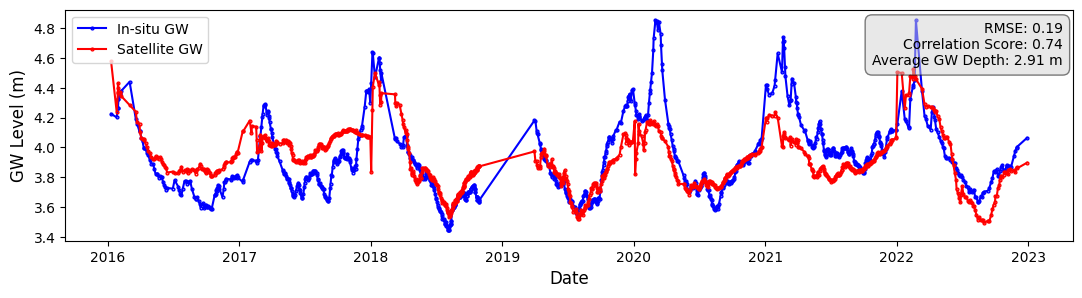

In [24]:
# Calculate RMSE
rmse = np.sqrt(((y_pred - cleaned_df['GW_level']) ** 2).mean())

# Calculate correlation
correlation = np.corrcoef(cleaned_df['GW_level'], y_pred1)[0, 1]
Depth = '2.91 m'
significance = '<0.05'

# Plot
fig, ax1 = plt.subplots(figsize=(13, 3))
ax1.plot(cleaned_df['datetime'], cleaned_df['GW_level'], label='In-situ GW', color='b', marker='o', markersize=2, markerfacecolor='none', markeredgecolor='b')
ax1.plot(cleaned_df['datetime'], y_pred1, label='Satellite GW', color='r', marker='o', markersize=2, markerfacecolor='none', markeredgecolor='r')
ax1.set_xlabel('Date', size=12)
ax1.set_ylabel('GW Level (m)', size=12)

# Calculate RMSE
rmse_text = f'RMSE: {rmse:.2f}'
correlation_text = f'Correlation Score: {correlation:.2f}'
bias_text = f'Average GW Depth: {Depth:}'
significance_text = f'Significance (p): {significance}'

# Combine all annotation text
combined_text = f'{rmse_text}\n{correlation_text}\n{bias_text}'

# Annotate combined text with grey background
ax1.annotate(combined_text, xy=(0.99, 0.76), xycoords='axes fraction', ha='right', fontsize=10, color='black', bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgrey', alpha=0.5))

#ax1.set_ylim(3.2, 5.2)

ax1.legend(loc='upper left')
plt.show()


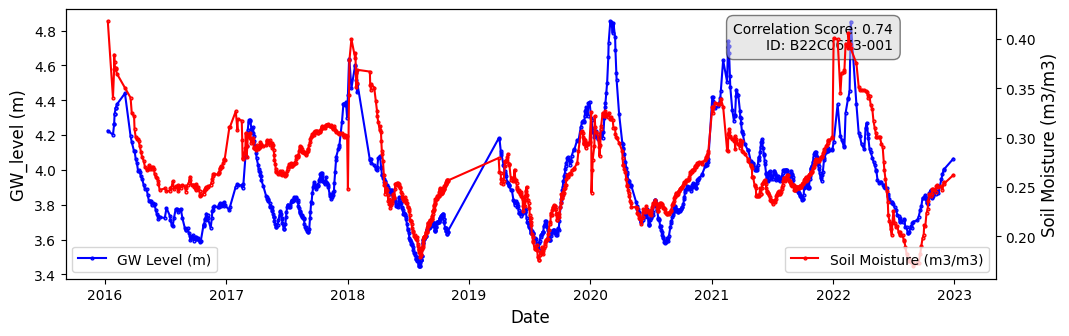

In [25]:
# Calculate correlation
correlation = np.corrcoef(cleaned_df['GW_level'], cleaned_df['vswi'])[0, 1]
# distance = '1988.08 m'
ID = 'B22C0673-001'

fig, ax1 = plt.subplots(figsize=(12, 3.5))
cleaned_df_sort = cleaned_df.sort_values(by='datetime')
ax1.plot(cleaned_df['datetime'], cleaned_df['GW_level'], label='GW Level (m)', color='b', marker='o', markersize=2, markerfacecolor='none', markeredgecolor='b')

ax2=ax1.twinx()
ax2.plot(cleaned_df['datetime'], cleaned_df['vswi'], label='Soil Moisture (m3/m3)', color='r', marker='o', markersize=2, markerfacecolor='none', markeredgecolor='r')
ax2.set_ylabel('Soil Moisture (m3/m3)', size=12)
ax1.set_xlabel('Date', size=12)
ax1.set_ylabel('GW_level (m)', size=12)

# Calculate RMSE
rmse_text = f'RMSE: {rmse:.2f}'
correlation_text = f'Correlation Score: {correlation:.2f}'
# bias_text = f'Distance to Abstraction: {distance:}'
ID_text = f'ID: {ID}'

# Combine all annotation text
combined_text = f'{correlation_text}\n{ID_text}'

# Annotate combined text with grey background
ax1.annotate(combined_text, xy=(0.89, 0.85), xycoords='axes fraction', ha='right', fontsize=10, color='black', bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgrey', alpha=0.5))
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

plt.show()


# **References**

*   Albergel, C., ¨ Udiger, C. R., Pellarin, T., Calvet, J.-C., Fritz, N., Froissard, F., Suquia, D., Petitpa, A., Piguet, B., & Martin, E. (2008). Hydrology and Earth System Sciences From near-surface to root-zone soil moisture using an exponential filter: an assessment of the method based on in-situ observations and model simulations. Hydrol. Earth Syst. Sci, 12, 1323–1337. www.hydrol-earth-syst-sci.net/12/1323/2008/
*   Benninga, H. J. F., van der Velde, R., & Su, Z. (2020). Sentinel-1 soil moisture content and its uncertainty over sparsely vegetated fields. Journal of Hydrology X, 9, 100066. https://doi.org/10.1016/J.HYDROA.2020.100066

* Benninga, H.-J. F., van de Velde, R., & Su, Z. (2019). Impacts of Radiometric Uncertainty and Weather Related Surface Conditions on Soil Moisture Retrievals with Sentinel-1. Remote Sensing.
* Wagner, W., Lemoine, G., & Rott, H. (1999). A Method for Estimating Soil Moisture from ERS Scatterometer and Soil Data. Remote Sensing of Environment, 70(2), 191–207. https://doi.org/10.1016/S0034-4257(99)00036-X


